In [501]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import hvplot.pandas

In [502]:
from os import listdir
from os.path import isfile

In [503]:
from sklearn.linear_model import LinearRegression

In [504]:
dir = "../Resources/"

In [505]:
all_files = [x for x in listdir(dir) if (".xlsx" in x or ".csv" in x)]
all_files

['corn.xlsx',
 'feeder_cattle.xlsx',
 'live_cattle.xlsx',
 'soybean_meal.xlsx',
 'lean_hogs.xlsx']

In [506]:
all_df = pd.DataFrame()
for x in all_files:
    a = x.replace(".xlsx", "")
    df = pd.read_excel(dir+x)
    df["name"] = a
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date")
    df = df.sort_index()
    df = df.dropna()
    df = df[df['Volume'] != 0.0]
    df.drop(['Volume'], axis=1, inplace=True)
    if a == "corn":
        corn = df
        all_df["corn"] = corn["Price"]
    elif a == "live_cattle":
        live_cattle = df
        all_df["live_cattle"] = live_cattle["Price"]
    elif a == "feeder_cattle":
        feeder_cattle = df
        all_df["feeder_cattle"] = feeder_cattle["Price"]
    elif a == "soybean_meal":
        soybean = df
        all_df["soybean"] = soybean["Price"]
    elif a == "lean_hogs":
        hog = df
        all_df["hog"] = hog["Price"]

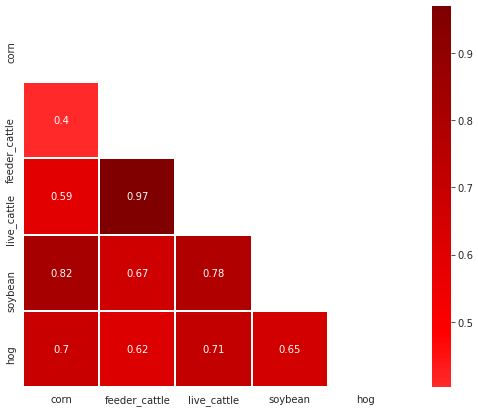

In [507]:
all_df = all_df.dropna()
corrM = all_df.corr()

mask = np.zeros_like(corrM)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10,7))
    ax = sns.heatmap(corrM, mask=mask, center=0, annot=True, square=True, linewidths=1, cmap="seismic")

In [508]:
all_df["corn_and_soybean"] = ((all_df["corn"]*3) + all_df["soybean"]).div(2)
all_df.head()

,corn,feeder_cattle,live_cattle,soybean,hog,corn_and_soybean
Date,,,,,,
2001-01-02,2.5825,89.875,77.150,176.4,47.800,92.07375
2001-01-04,2.6100,89.500,76.650,173.8,48.000,90.81500
2001-01-05,2.5800,89.500,76.300,171.7,48.000,89.72000
2001-01-08,2.5800,89.150,75.800,172.3,48.300,90.02000
2001-01-09,2.5925,89.200,76.375,174.2,48.275,90.98875


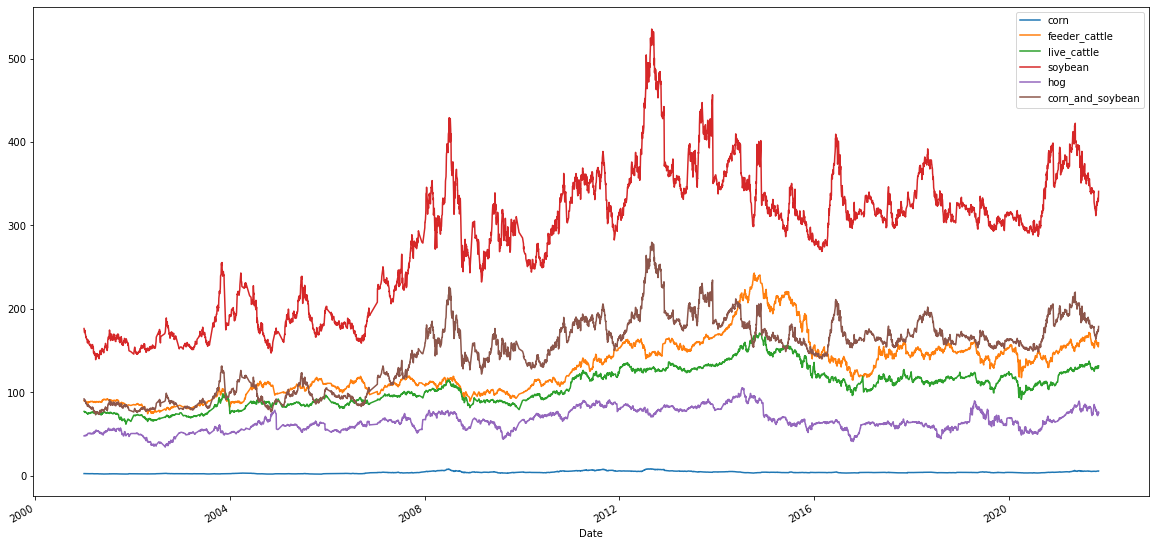

In [509]:
all_df.plot(figsize=(20,10));

In [510]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [511]:
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 5
target_column = 4
X, y = window_data(all_df, window_size, feature_column, target_column)

In [512]:
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [513]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()

scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [514]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [515]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [516]:
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape = (X_train.shape[1],1))
         )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units = number_units,
    return_sequences = True,
        ))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units = number_units,
    return_sequences = False,
        ))
model.add(Dropout(dropout_fraction))

model.add(Dense(1))

In [517]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [518]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 30)            3840      
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [ ]:
epochs = 50
batch_size = 10
model.fit(X_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/50
327/327 [==============================] - 24s 42ms/step - loss: 0.0135
Epoch 2/50
327/327 [==============================] - 15s 47ms/step - loss: 0.0143
Epoch 3/50
327/327 [==============================] - 19s 59ms/step - loss: 0.0161
Epoch 4/50
327/327 [==============================] - 29s 88ms/step - loss: 0.0189 0s - loss:  - ETA: 0s - loss: 0.0
Epoch 5/50
327/327 [==============================] - 32s 97ms/step - loss: 0.0200
Epoch 6/50
327/327 [==============================] - 24s 73ms/step - loss: 0.0226
Epoch 7/50
327/327 [==============================] - 13s 39ms/step - loss: 0.0229
Epoch 8/50
327/327 [==============================] - 12s 37ms/step - loss: 0.0229
Epoch 9/50
327/327 [==============================] - 14s 43ms/step - loss: 0.0237
Epoch 10/50
327/327 [==============================] - 24s 73ms/step - loss: 0.0256
Epoch 11/50
147/327 [============>.................] - ETA: 20s - loss: 0.0253

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
predicted = model.predict(X_test)

In [ ]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
hogs = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
hogs.head()

In [ ]:
hogs.hvplot.line(xlabel="Date", ylabel="Price")